In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install -Uqq fastai
!pip install timm

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.0 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.6.4 which is incompatible.
pandas-profiling 3.1.0 requires mar

In [2]:
from fastai.vision.all import *
import timm
path = Path('../input/kaggle-pog-series-s01e03/corn')
path.ls()
df = pd.read_csv(path/'train.csv')

In [3]:
set_seed(20)

In [4]:
dls = ImageDataLoaders.from_df(df, path, valid_pct=0.2,seed=20,
                               fn_col='image', label_col='label',
                               item_tfms=Resize(280, method='squish'),
                               batch_tfms=aug_transforms(size=224, flip_vert=True))

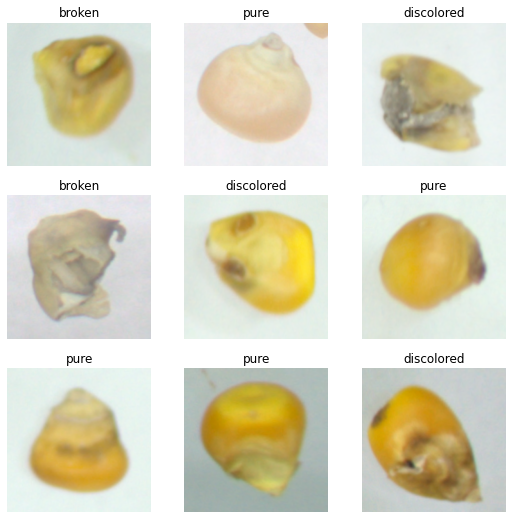

In [5]:
dls.show_batch()

In [6]:
timm.list_models('*swin_base_patch4_window7_224_in22k*')

['swin_base_patch4_window7_224_in22k']

In [7]:
learn = vision_learner(dls, 'swin_base_patch4_window7_224_in22k', metrics=[accuracy,error_rate], path='.').to_fp16()

/opt/conda/lib/python3.7/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22k.pth


In [8]:
learn.fine_tune(8, 0.005,cbs=[SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.071508,0.755688,0.698673,0.301327,03:19


Better model found at epoch 0 with valid_loss value: 0.7556883096694946.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.723899,0.609146,0.755587,0.244413,04:15
1,0.654694,0.579530,0.764665,0.235335,04:15
2,0.593202,0.583818,0.756983,0.243017,04:15
3,0.522481,0.525569,0.787360,0.212640,04:15
4,0.490704,0.512180,0.793994,0.206006,04:15
5,0.433391,0.497541,0.797835,0.202165,04:15
6,0.399585,0.499120,0.802723,0.197277,04:15
7,0.375343,0.503186,0.804469,0.195531,04:15


Better model found at epoch 0 with valid_loss value: 0.6091458797454834.
Better model found at epoch 1 with valid_loss value: 0.5795301198959351.
Better model found at epoch 3 with valid_loss value: 0.5255690217018127.
Better model found at epoch 4 with valid_loss value: 0.5121800899505615.
Better model found at epoch 5 with valid_loss value: 0.49754083156585693.


In [9]:
learn.save('first_0.005')
learn.save('first_0.005_no_opt',with_opt=False)

Path('models/first_0.005_no_opt.pth')

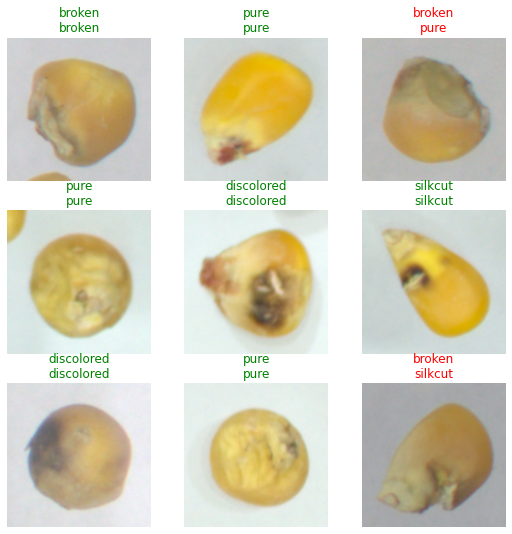

In [10]:
learn.show_results()

In [11]:
learn.fine_tune(4, 0.0005,cbs=[SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.400746,0.500823,0.800279,0.199721,03:16


Better model found at epoch 0 with valid_loss value: 0.5008227229118347.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.402520,0.501979,0.800628,0.199372,04:15
1,0.377223,0.497539,0.801327,0.198673,04:15
2,0.378454,0.498014,0.802025,0.197975,04:15
3,0.375663,0.506527,0.802025,0.197975,04:15


Better model found at epoch 0 with valid_loss value: 0.5019790530204773.
Better model found at epoch 1 with valid_loss value: 0.4975392818450928.


In [12]:
learn.save('first_0.0005')
learn.save('first_0.0005_no_opt',with_opt=False)

Path('models/first_0.0005_no_opt.pth')

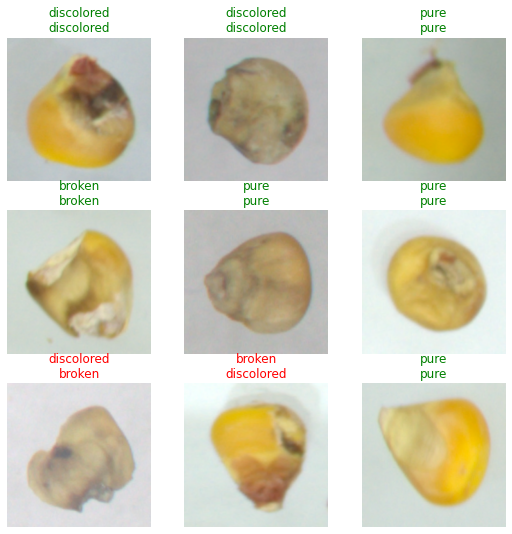

In [13]:
learn.show_results()

In [14]:
learn.fine_tune(4, 0.00001,cbs=[SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.369696,0.501276,0.800279,0.199721,03:16


Better model found at epoch 0 with valid_loss value: 0.5012760758399963.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.381372,0.503634,0.799581,0.200419,04:15
1,0.360744,0.503175,0.799232,0.200768,04:15
2,0.374590,0.498590,0.801327,0.198673,04:15
3,0.367539,0.501112,0.800628,0.199372,04:15


Better model found at epoch 0 with valid_loss value: 0.5036340355873108.
Better model found at epoch 1 with valid_loss value: 0.5031754970550537.
Better model found at epoch 2 with valid_loss value: 0.49859023094177246.


In [15]:
learn.save('first_0.00001')
learn.save('first_0.00001_no_opt',with_opt=False)

Path('models/first_0.00001_no_opt.pth')

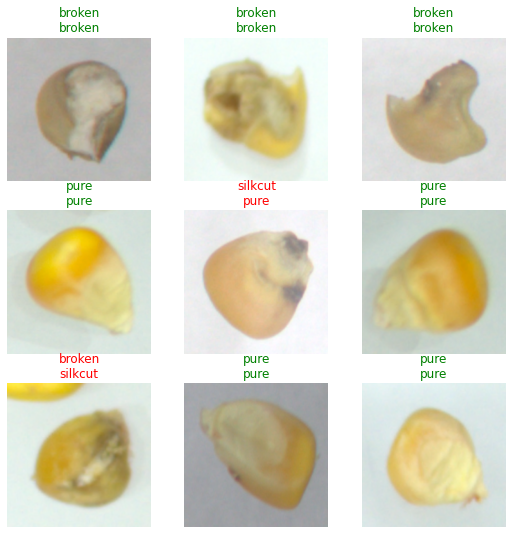

In [16]:
learn.show_results()

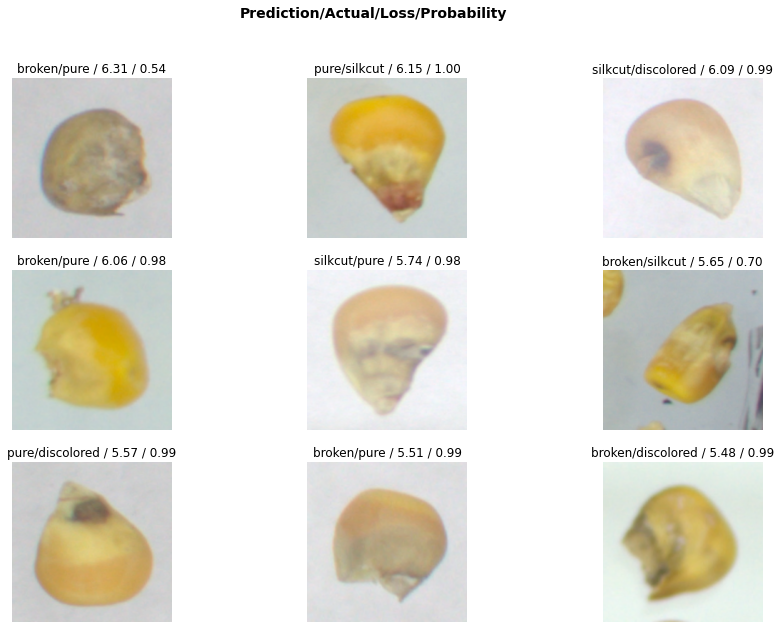

In [17]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

In [18]:
tst_files = get_image_files(path/'test').sorted()
tst_dl = dls.test_dl(tst_files)

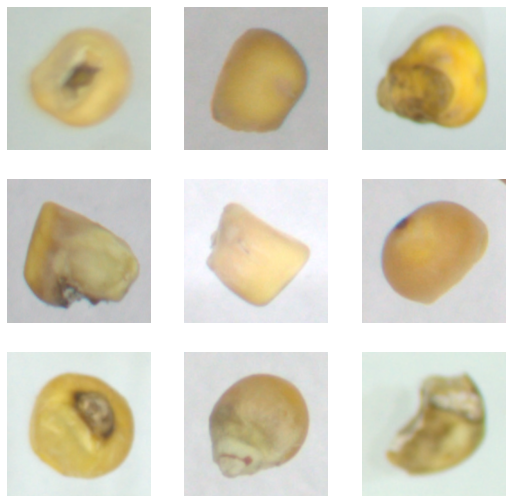

In [19]:
tst_dl.show_batch()

In [20]:
tta_preds,_ = learn.tta(dl=tst_dl)
idxs = tta_preds.argmax(dim=1)

In [21]:
dls.vocab

['broken', 'discolored', 'pure', 'silkcut']

In [22]:
results = pd.Series(dls.vocab[idxs], name="idxs")
results

0           broken
1             pure
2             pure
3           broken
4           broken
           ...    
3474    discolored
3475    discolored
3476          pure
3477          pure
3478          pure
Name: idxs, Length: 3479, dtype: object

In [23]:
sub = pd.read_csv(path/'test.csv', usecols=['seed_id'])
sub

,seed_id
0,2
1,11
2,13
3,19
4,27
...,...
3474,17775
3475,17781
3476,17790
3477,17794


In [24]:
sub['label'] = results
sub.to_csv('submission.csv', index=False)
!head subm.csv

head: cannot open 'subm.csv' for reading: No such file or directory


In [25]:
sub.label.value_counts()

pure          1486
broken        1120
discolored     541
silkcut        332
Name: label, dtype: int64

In [26]:
learn.fine_tune(1, 0.000001,cbs=[SaveModelCallback()])

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.378291,0.502980,0.802025,0.197975,03:16


Better model found at epoch 0 with valid_loss value: 0.5029797554016113.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.376561,0.499578,0.800628,0.199372,04:42


Better model found at epoch 0 with valid_loss value: 0.49957752227783203.
